## Laplace Log Likelihood
![](https://i.imgur.com/tEIZvli.png)
*Image Credits: https://en.wikipedia.org/wiki/Laplace_distribution*

The evaluation metric of this competition is a modified version of Laplace Log Likelihood. Read more about it on the [Evaluation Page](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview/evaluation).

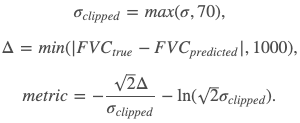

This notebook explores the functioning of this metric with some examples and visualizations.


In [ ]:
## importing packages
import numpy as np
import pandas as pd
import seaborn as sns

from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, CustomJS, Label, Range1d, Slider, Span
from bokeh.plotting import figure, output_notebook, show

output_notebook()

## reading data
df_train = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")


## FVC Distribution
Let's look at the distribution of the target variable **FVC**.


In [ ]:
sns.distplot(df_train.FVC, color = "brown");

FVC ranges from **827 to 6399** and seems to have a (visually) normal distribution with **mean 2690** and **standard deviation 833**.

## Evaluation Metric
Note that not only do we need to predict the FVC but also a confidence value of the prediction. The term *confidence* is a bit confusing (as lower value means more confident) and it might be better to just consider it as the *standard deviation* (or the *uncertainty*).   

Let's define a function and then use it with some examples and understand the metric.


In [ ]:
## evaluation metric function
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark
laplace_log_likelihood(df_train.FVC, np.mean(df_train.FVC), np.std(df_train.FVC))


**-8.023** is the default score to beat while cross-validating models on train data. Any model scoring worse than this is not useful. You can get this default score to beat for each (fold of) validation data as well.

## Constant Prediction
Let's try out a few combinations of predicting a constant value for FVC as well as confidence to compare how the errors vary with the actual FVC values.


In [ ]:
def plot_metric_constants(actual_fvc, constant_fvc, constant_confidence):
    """
    Generatings a bokeh plot for a constant value of predicted FVC and confidence.
    """
    lll = laplace_log_likelihood(actual_fvc, constant_fvc, constant_confidence)

    df = pd.DataFrame({
        "actual_FVC": actual_fvc,
        "predicted_FVC": constant_fvc,
        "confidence": constant_confidence,
        "metric": laplace_log_likelihood(actual_fvc, constant_fvc, constant_confidence, return_values = True)
    }).sort_values("actual_FVC")
    
    source = ColumnDataSource(df)
    
    tooltips = [
        ("Actual FVC", "@actual_FVC{0}"),
        ("Predicted FVC", "@predicted_FVC{0}"),
        ("Confidence", "@confidence{0}"),
        ("Metric", "@metric{0.000}")
    ]
    
    v = figure(
        plot_width = 345,
        plot_height = 345,
        y_range = Range1d(-4, -25),
        tooltips = tooltips,
        title = f"Metric values for FVC = {constant_fvc}, Confidence = {constant_confidence}"
    )

    v.circle("actual_FVC", "metric", source = source, size = 3, color = "deepskyblue", alpha = 0.8)
    
    mean = Span(
        location = lll,
        dimension = "width",
        line_color = "red",
        line_dash = "dashed",
        line_width = 1.5
    )

    v.add_layout(mean)
    
    score = Label(
        x = 3500,
        y = lll + 1.25,
        text = f"Laplace Log Likelihood = {round(lll, 3)}",
        text_font_size = "7pt"
    )

    v.add_layout(score)
    
    v.xaxis.axis_label = "Actual FVC"
    v.yaxis.axis_label = "Metric Value"

    return v


v1 = plot_metric_constants(df_train.FVC, 2690, 100)
v2 = plot_metric_constants(df_train.FVC, 2000, 100)
v3 = plot_metric_constants(df_train.FVC, 3000, 100)
v4 = plot_metric_constants(df_train.FVC, 4000, 100)

v5 = plot_metric_constants(df_train.FVC, 2000, 833)
v6 = plot_metric_constants(df_train.FVC, 2690, 833)
v7 = plot_metric_constants(df_train.FVC, 3000, 833)
v8 = plot_metric_constants(df_train.FVC, 4000, 833)

v9 = plot_metric_constants(df_train.FVC, 2690, 70)
v10 = plot_metric_constants(df_train.FVC, 2690, 100)
v11 = plot_metric_constants(df_train.FVC, 2690, 833)
v12 = plot_metric_constants(df_train.FVC, 2690, 1000)

show(column(row(v1, v2), row(v3, v4), row(v5, v6), row(v7, v8), row(v9, v10), row(v11, v12)))


## Interactive Simulation
You can play around with combinations of FVC values to see how the metric value varies over confidence.

* Any difference between the FVC values greater than 1000 will yield the same metric values since the delta is capped at 1000. 
* The metric value is only dependent on the difference of FVC values and not on the absolute values.


In [ ]:
source = ColumnDataSource(data = dict(
    x = range(70, 2001),
    y = [- np.sqrt(2) * 500 / x - np.log(np.sqrt(2) * x) for x in range(70, 2001)]
))

tooltips = [
    ("Confidence", "@x"),
    ("Metric", "@y")
]

v1 = figure(
    plot_width = 300,
    plot_height = 300,
    tooltips = tooltips,
    title = "Metric values across confidence"
)

v1.line("x", "y", source = source, width = 4, color = "coral", alpha = 0.8)

v1.y_range.flipped = True

v1.xaxis.axis_label = "Confidence (Uncertainty)"
v1.yaxis.axis_label = "Metric Value"

v2 = figure(
    plot_width = 300,
    plot_height = 300,
    tooltips = tooltips,
    y_range = Range1d(-4, -25),
    title = "Metric values across confidence"
)

v2.line("x", "y", source = source, width = 4, color = "coral", alpha = 0.8)

v2.xaxis.axis_label = "Confidence (Uncertainty)"
v2.yaxis.axis_label = "Metric Value"


slider_actual_FVC = Slider(start = 827, end = 6399, value = 2500, step = 1, title = "Actual FVC")
slider_predicted_FVC = Slider(start = 827, end = 6399, value = 3000, step = 1, title = "Predicted FVC")

callback = CustomJS(args = dict(
    source = source,
    actual_FVC = slider_actual_FVC,
    predicted_FVC = slider_predicted_FVC
), code = """
    var data = source.data
    var actual_FVC = actual_FVC.value
    var predicted_FVC = predicted_FVC.value

    var x = data['x']
    var y = data['y']
    var delta = Math.min(Math.abs(actual_FVC - predicted_FVC), 1000)

    for (var i = 0; i < x.length; i++) {
        y[i] = - Math.sqrt(2) * delta / x[i] - Math.log(Math.sqrt(2) * x[i])
    }

    source.change.emit();
""")

slider_actual_FVC.js_on_change("value", callback)
slider_predicted_FVC.js_on_change("value", callback)

show(column(slider_actual_FVC, slider_predicted_FVC, row(v1, v2)))


While ML models optimize on the point predictions of a target variable (like FVC), it will be interesting to see how the confidence predictions can be optimized. I'm sure through the course of the competition we will see some interesting approaches for the same.

## ML Prediction
Let's look at the out-of-fold predictions of some of the ML models. The example used below are the predictions from this kernel: https://www.kaggle.com/yasufuminakama/osic-lgb-baseline


In [ ]:
df_preds = pd.read_csv("/kaggle/input/osic-lgb-baseline-predictions/train.csv")

def plot_fvc_metric_model(actual_fvc, predicted_fvc, predicted_confidence, constant = False):
    """
    Generatings a bokeh plot for the metric values across actual values of FVC.
    """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    metric_values = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence, return_values = True)

    df = pd.DataFrame({
        "actual_FVC": actual_fvc,
        "predicted_FVC": predicted_fvc,
        "confidence": predicted_confidence,
        "metric": metric_values
    }).sort_values("actual_FVC")
    
    source = ColumnDataSource(df)
    
    tooltips = [
        ("Actual FVC", "@actual_FVC{0}"),
        ("Predicted FVC", "@predicted_FVC{0}"),
        ("Confidence", "@confidence{0}"),
        ("Metric", "@metric{0.000}")
    ]
    
    if type(predicted_confidence) != int:
        title = f"Metric values over FVC"
        offset = 0.35
    else:
        title = f"Metric values over FVC (Confidence = {predicted_confidence})"
        offset = 0.11
    
    v = figure(
        plot_width = 600,
        plot_height = 600,
        y_range = Range1d(max(metric_values) + 0.5, min(metric_values) - 0.5),
        tooltips = tooltips,
        title = title
    )

    v.circle("actual_FVC", "metric", source = source, size = 3, color = "mediumseagreen", alpha = 0.8)
    
    mean = Span(
        location = lll,
        dimension = "width",
        line_color = "red",
        line_dash = "dashed",
        line_width = 1.5
    )

    v.add_layout(mean)
    
    score = Label(
        x = 3750,
        y = lll + offset,
        text = f"Laplace Log Likelihood = {round(lll, 3)}",
        text_font_size = "12pt"
    )

    v.add_layout(score)
    
    v.xaxis.axis_label = "Actual FVC"
    v.yaxis.axis_label = "Metric Value"

    return v


def plot_confidence_metric_model(actual_fvc, predicted_fvc, predicted_confidence):
    """
    Generatings a bokeh plot for the metric values across predicted values of confidence.
    """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    metric_values = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence, return_values = True)

    df = pd.DataFrame({
        "actual_FVC": actual_fvc,
        "predicted_FVC": predicted_fvc,
        "confidence": predicted_confidence,
        "metric": metric_values
    }).sort_values("confidence")
    
    source = ColumnDataSource(df)
    
    tooltips = [
        ("Actual FVC", "@actual_FVC{0}"),
        ("Predicted FVC", "@predicted_FVC{0}"),
        ("Confidence", "@confidence{0}"),
        ("Metric", "@metric{0.000}")
    ]
    
    v = figure(
        plot_width = 600,
        plot_height = 600,
        y_range = Range1d(max(metric_values) + 0.5, min(metric_values) - 0.5),
        tooltips = tooltips,
        title = "Metric values over Confidence"
    )

    v.circle("confidence", "metric", source = source, size = 3, color = "gold", alpha = 0.8)
    
    mean = Span(
        location = lll,
        dimension = "width",
        line_color = "red",
        line_dash = "dashed",
        line_width = 1.5
    )

    v.add_layout(mean)
    
    score = Label(
        x = 600,
        y = lll + 0.35,
        text = f"Laplace Log Likelihood = {round(lll, 3)}",
        text_font_size = "12pt"
    )

    v.add_layout(score)
    
    v.xaxis.axis_label = "Predicted Confidence"
    v.yaxis.axis_label = "Metric Value"

    return v


def plot_pred_metric_model(actual_fvc, predicted_fvc, predicted_confidence):
    """
    Generatings a bokeh plot for the metric values across predicted values of FVC.
    """
    lll = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence)
    metric_values = laplace_log_likelihood(actual_fvc, predicted_fvc, predicted_confidence, return_values = True)

    df = pd.DataFrame({
        "actual_FVC": actual_fvc,
        "predicted_FVC": predicted_fvc,
        "confidence": predicted_confidence,
        "metric": metric_values
    }).sort_values("predicted_FVC")
    
    source = ColumnDataSource(df)
    
    tooltips = [
        ("Actual FVC", "@actual_FVC{0}"),
        ("Predicted FVC", "@predicted_FVC{0}"),
        ("Confidence", "@confidence{0}"),
        ("Metric", "@metric{0.000}")
    ]
    
    v = figure(
        plot_width = 600,
        plot_height = 600,
        y_range = Range1d(max(metric_values) + 0.5, min(metric_values) - 0.5),
        tooltips = tooltips,
        title = "Metric values over predicted FVC"
    )

    v.circle("predicted_FVC", "metric", source = source, size = 3, color = "turquoise", alpha = 0.8)
    
    mean = Span(
        location = lll,
        dimension = "width",
        line_color = "red",
        line_dash = "dashed",
        line_width = 1.5
    )

    v.add_layout(mean)
    
    score = Label(
        x = 3500,
        y = lll + 0.35,
        text = f"Laplace Log Likelihood = {round(lll, 3)}",
        text_font_size = "12pt"
    )

    v.add_layout(score)
    
    v.xaxis.axis_label = "Predicted FVC"
    v.yaxis.axis_label = "Metric Value"

    return v


sns.pairplot(df_preds[["FVC", "FVC_pred", "Confidence"]]);


In [ ]:
v1 = plot_fvc_metric_model(df_preds.FVC, df_preds.FVC_pred, df_preds.Confidence)
v2 = plot_fvc_metric_model(df_preds.FVC, df_preds.FVC_pred, 833)

show(column(v1, v2))


Optimizing the confidence predictions through a model or optimizer scores **-6.851** like what was done in this model / submission which is better than if just the standard deviation was used to predict confidence which scores **-7.373**. There are some interesting approaching shared in public baseline notebooks of how confidence predictions can be optimized.


In [ ]:
v1 = plot_confidence_metric_model(df_preds.FVC, df_preds.FVC_pred, df_preds.Confidence)
v2 = plot_pred_metric_model(df_preds.FVC, df_preds.FVC_pred, df_preds.Confidence)

show(column(v1, v2))


You can clearly see that if you predict a value with high error and low standard deviation it can lead to large penalties. On the flip side if you predict values with high standard deviation the range of penalties is higher. So that's what you need to balance while optimizing the predictions!
